In [6]:
import chess
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikitricky/chess-positions")

print("Path to dataset files:", path)

/Users/anandh/Desktop/Projects/mystic-bot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/anandh/.cache/kagglehub/datasets/nikitricky/chess-positions/versions/2


In [8]:
import pandas as pd

all_positions = pd.read_csv("./sample/benchmarks/positions.csv")


/var/folders/wl/rrzy6_2s3sz2s52k6tj1mrqh0000gq/T/ipykernel_13500/183767479.py:3: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_positions = pd.read_csv("./sample/benchmarks/positions.csv")


In [9]:
positions = all_positions.sample(n= 100, random_state=1)
positions

,fen,playing,score,mate,depth,game_id,date,time,white,black,white_result,black_result,white_elo,black_elo,opening,time_control,termination
982217,8/rn3kpp/5p2/3n4/4R3/3Pp3/2K1P3/8 w - - 2 43,b6d5,-1071.0,NaN,21,zqj8lhtv,2013.01.04,21:14:37,albertCamus,JPPP,0,1,1284,1182,Zukertort Opening: Arctic Defense,480+0,Normal
1032314,8/5p2/4k1p1/7p/1rK4P/8/8/1r6 w - - 2 58,b5b4,NaN,-4.0,245,22cm8ulo,2013.01.05,02:55:11,GaneshKanna,ZebraKing,0,1,1363,1738,King's Pawn Game: Wayward Queen Attack,300+0,Normal
145767,8/p6k/1r6/8/8/5K2/8/8 b - - 4 74,e2f3,NaN,11.0,56,dtm406oq,2013.01.01,17:26:36,PetWussy,garderob,1/2,1/2,1981,1939,Blackmar-Diemer Gambit: Gedult Gambit,60+0,Time forfeit
421155,6k1/2p3pp/p3p3/2N1n3/2P2p2/1P3PnP/r5P1/4K1R1 w...,d2a2,-971.0,NaN,22,5dype3wu,2013.01.02,20:04:20,Skar,flatron1,0,1,1394,1663,French Defense: King's Indian Attack,300+1,Normal
125961,2k5/2p5/p1pp1p2/4p1p1/4P3/P1PPBK2/2P2P2/8 w - ...,b7c6,571.0,NaN,24,nu9fl1fp,2013.01.01,16:05:53,kent777,garderob,1,0,1773,1927,Italian Game: Anti-Fried Liver Defense,60+0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528845,8/1R1bk3/5p1r/4RBp1/8/2P5/5PPP/6K1 b - - 0 30,e1e5,-567.0,NaN,24,50hh180f,2013.01.03,08:10:28,sani5057,Avishek,1,0,1560,1445,Semi-Slav Defense: Accelerated Move Order,300+3,Normal
584173,1n4k1/p1r3pp/4p1q1/5n2/2PB4/P4Q2/2P2PPP/3RR1K1...,e7f5,593.0,NaN,25,r0wwomj0,2013.01.03,13:39:11,pzd060,kikeillana,1,0,1500,1563,Scandinavian Defense: Mieses-Kotroc Variation,120+0,Normal
546286,r4rk1/1b1q1pbp/p2p1np1/1pp5/3PP3/PB5P/1P1PQPP1...,c3d4,142.0,NaN,23,lqq8pinj,2013.01.03,10:35:52,a1ngel5,Tukeke,0,1,1337,1424,Philidor Defense #2,480+8,Time forfeit
145930,4r1k1/3n1pp1/1p5p/p3P3/P2PnPP1/4BR2/2q3QP/R5K1...,d2e3,-423.0,NaN,23,6e46704m,2013.01.01,17:27:35,rennigeb,jmcd,0,1,1500,1697,Slav Defense,600+3,Normal


In [10]:
boards: list[chess.Board] = []
for fen in positions['fen']:
    boards.append(chess.Board(fen=fen))

In [11]:
num_moves = []

for board in boards:
    num_moves.append((board.fullmove_number-1)*2 + (board.turn == chess.BLACK))

In [42]:
def plot_histogram(move_counts):
    # Plot histogram
    plt.figure(figsize=(10, 6))
    move_frequency = Counter(move_counts)
    # plt.hist(move_counts, bins=20)
    plt.bar(move_frequency.keys(), move_frequency.values(), color='skyblue')
    plt.xlabel('Number of Moves')
    plt.ylabel('Frequency')
    plt.title('Histogram of Number of Moves')
    plt.show()

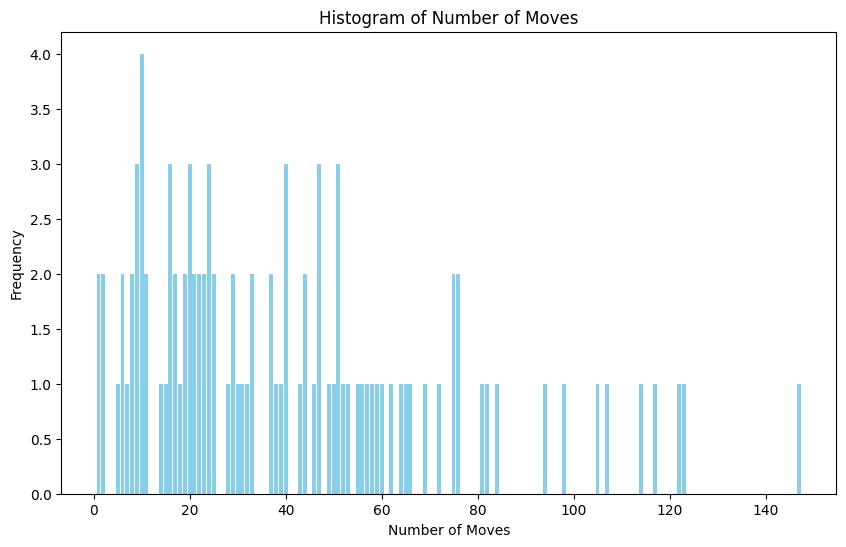

In [43]:
plot_histogram(num_moves)

In [17]:
import json
def boardToBitMap(board):
   pieceStructMap = {
      "r": "rooks",
      "n": "knights",
      "b": "bishops",
      "k": "kings",
      "q": "queens",
      "p": "pawns",
   }

   boardBitMap = {
      "rooks": 0,
      "knights": 0,
      "bishops": 0,
      "queens": 0,
      "kings": 0,
      "pawns": 0,
      "metadata": 0,
      "latest_move": 0
   }

   for index, piece in board.piece_map().items():
      isBlack = piece.symbol().islower()
      effIndex = 64*isBlack + ( 63 - index )
      boardBitMap[ pieceStructMap[ piece.symbol().lower() ] ] |= 1 << effIndex

   metadata = 0
   metadata |= board.fullmove_number << 16
   metadata |= board.halfmove_clock << 9
   metadata |= board.turn << 8
   en_passant_square = board.ep_square
   metadata |= bool( en_passant_square ) << 7
   if en_passant_square:
      column_number = chess.square_file(en_passant_square)
      metadata |= column_number << 4
   metadata |= board.has_kingside_castling_rights(0) << 3
   metadata |= board.has_queenside_castling_rights(0) << 2
   metadata |= board.has_kingside_castling_rights(1) << 1
   metadata |= board.has_queenside_castling_rights(1) << 0
   boardBitMap[ 'metadata' ] = metadata

   return boardBitMap

def bitMapFile( fileName, bitMap=None, isRead=True ):
   if isRead:
      with open(fileName, "r+") as f: 
         bitMap = json.load(f)
         return bitMap
   else:
      assert bitMap is not None, "No bitMap provided  to save!"
      with open(fileName, "w+") as f: 
         json.dump(bitMap, f, indent=2)



In [65]:
import subprocess

def get_best_move(board):
    executable = "./target/release/mystic-bot"
    writeFile = f"./tmp.json"
    timeLimitInMs = "10000"
    bitMapFile(writeFile, boardToBitMap(board), isRead=False)
    result = subprocess.run(
        [executable, writeFile, timeLimitInMs],
        check=True,
        capture_output=True,
        text=True
    )
    return result

In [144]:
import re

def get_time_taken(string):
    match = re.search(r"Time Taken: (\d+)", string)

    if match:
        time_taken = int(match.group(1))
        return time_taken
    else:
        return 0

In [148]:
results = []
for board in boards:
    results.append(get_best_move(board))

In [149]:
time_taken = []
for result in results:
    time_taken.append(get_time_taken(result.stdout))

In [150]:
import numpy as np

time_taken_np = np.array(time_taken)
time_taken_np.mean()

np.float64(510.13)

Text(0.5, 1.0, 'time taken to find a move after num moves')

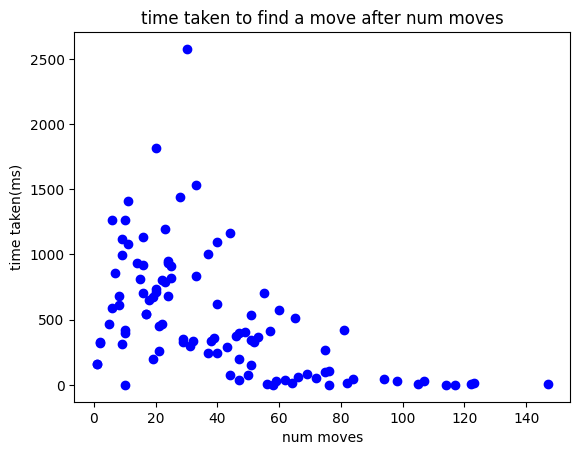

In [152]:
plt.scatter(num_moves, time_taken, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('num moves')
plt.ylabel('time taken(ms)')
plt.title('time taken to find a move after num moves')